In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Conv2D,Flatten,MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn import metrics
from datetime import datetime
import soundfile as sf
import os
import glob
import random

import tqdm
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load cơ sở dữ liệu

In [ ]:
feature_sets = np.load('/content/drive/MyDrive/wakeword/wakeword_feature.npz')
X_train_data = feature_sets['x_train']
y_train_data = feature_sets['y_train']
X_val_data = feature_sets['x_val']
y_val_data = feature_sets['y_val']
X_test_data = feature_sets['x_test']
y_test_data = feature_sets['y_test']

In [ ]:
X_train_data.shape

(45144, 34, 36)

# Build mô hình DS-CNN

In [ ]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import (
    Input, Flatten, Dropout, Activation, BatchNormalization, DepthwiseConv2D,
    Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, MaxPool2D,
    Dense, Embedding, LSTM,Reshape
)
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

def DS_CNN_model(input_shape, nclass):

    input_ = Input(input_shape)
    X = Reshape((-1,36, 1), name="expand_dim")(input_)
    X = Convolution2D(100, (3, 3), activation="relu", dilation_rate=(2, 1), strides=(1, 1), padding="valid")(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)

    X = DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), dilation_rate=(1,1), padding='valid')(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    X = Convolution2D(100, kernel_size=(1,1))(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)

    X = DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), dilation_rate=(2,2), padding='valid')(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    X = Convolution2D(100, kernel_size=(1,1))(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)

    X = DepthwiseConv2D(kernel_size=(10,3), strides=(1,1), dilation_rate=(1,1), padding='valid')(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)
    X = Convolution2D(100, kernel_size=(1,1))(X)
    X = BatchNormalization(momentum=0.98, center=True, scale=False, renorm=False)(X)
    X = Activation('relu')(X)

    X = AveragePooling2D(pool_size=(X.shape[1], X.shape[2]))(X)

    X = Flatten()(X)
    X = Dropout(rate=0.2)(X)
    output_ = Dense(nclass, activation='sigmoid')(X)

    ret_model = Model(inputs = input_, outputs=output_)

    return ret_model
model = DS_CNN_model(input_shape=(34,36), nclass=1)
model.summary()
#return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34, 36)]          0         
                                                                 
 expand_dim (Reshape)        (None, 34, 36, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 34, 100)       1000      
                                                                 
 batch_normalization (Batch  (None, 30, 34, 100)       300       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 30, 34, 100)       0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 28, 32, 100)       1000      
 eConv2D)                                                    

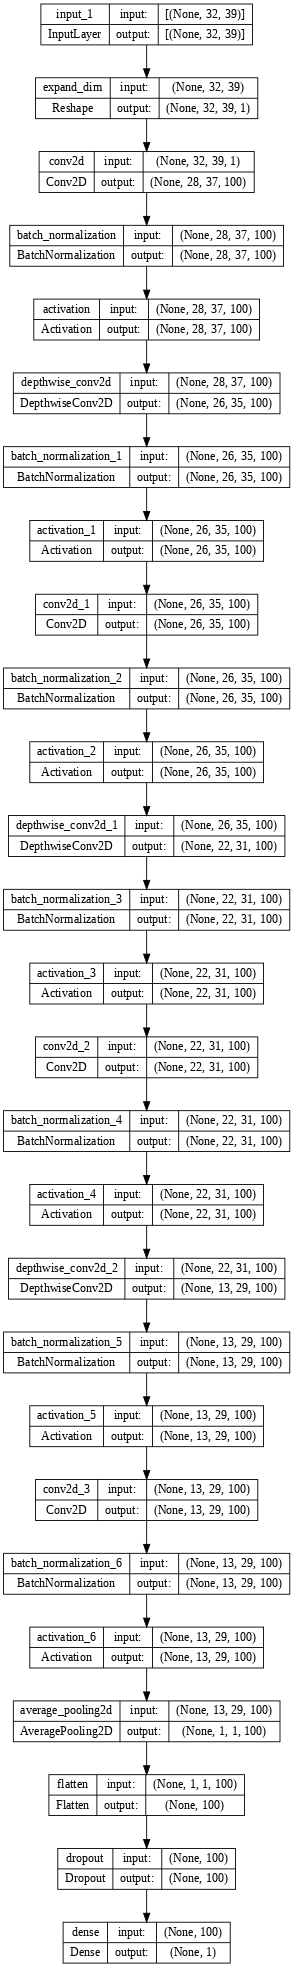

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

# Train mô hình DS-CNN

In [ ]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
tensorboard = TensorBoard(log_dir="logs")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                         save_best_only=True,
                                                         save_weights_only=False,
                                                         monitor='loss',
                                                         mode='min',
                                                         verbose=1)
epochs = 500
batch_size = 128
# train the model using the training set and validating using validation set
history = model.fit(X_train_data,y_train_data, epochs=epochs,batch_size=batch_size,
          callbacks=[tensorboard,checkpoint_callback])

Epoch 1/500
353/353 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9521
Epoch 1: loss improved from inf to 0.13921, saving model to best_model.h5
353/353 [==============================] - 29s 57ms/step - loss: 0.1392 - accuracy: 0.9521
Epoch 2/500
  2/353 [..............................] - ETA: 19s - loss: 0.0691 - accuracy: 0.9805

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/353 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9911
Epoch 2: loss improved from 0.13921 to 0.03130, saving model to best_model.h5
353/353 [==============================] - 19s 55ms/step - loss: 0.0313 - accuracy: 0.9911
Epoch 3/500
352/353 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9945
Epoch 3: loss improved from 0.03130 to 0.01931, saving model to best_model.h5
353/353 [==============================] - 20s 57ms/step - loss: 0.0193 - accuracy: 0.9945
Epoch 4/500
352/353 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9955
Epoch 4: loss improved from 0.01931 to 0.01430, saving model to best_model.h5
353/353 [==============================] - 20s 56ms/step - loss: 0.0143 - accuracy: 0.9955
Epoch 5/500
352/353 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9968
Epoch 5: loss improved from 0.01430 to 0.01046, saving model to best_model.h5
353/353 [==============================

# Đánh giá mô hình DS-CNN

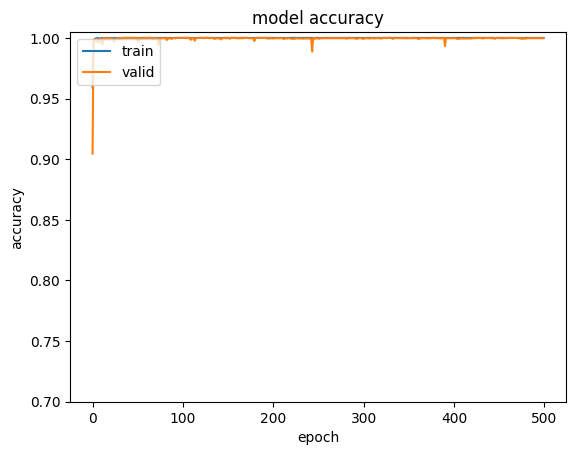

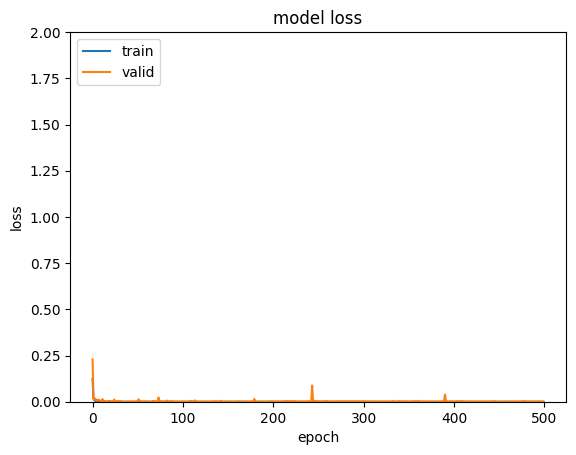

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.7,)
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,2)
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test_data,y_test_data)

125/125 [==============================] - 1s 7ms/step - loss: 6.2994e-04 - accuracy: 0.9997


[0.0006299364031292498, 0.999749481678009]

In [ ]:
def decode_label(pred):
  if pred>=0.5:
    return 'lisa oi'
  else:
    return 'noise'
ground_true = []
preds = []
for i in range(0,len(y_test_data)):
  ground_true.append(decode_label(y_test_data[i]))
  feature = X_test_data[i].reshape(1,32,39)
  pre = keras_model.predict(feature,verbose=0)
  result = decode_label(pre)
  preds.append(result)

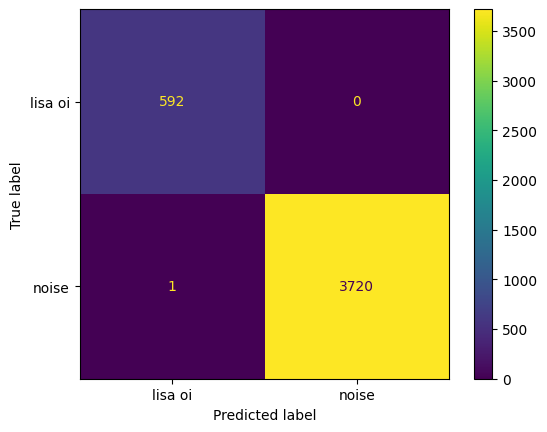

In [ ]:
conf_matrix = confusion_matrix(ground_true,preds,labels = ['lisa oi','noise'])
disp = ConfusionMatrixDisplay( confusion_matrix=conf_matrix, display_labels=['lisa oi','noise'])
disp.plot()
plt.show()

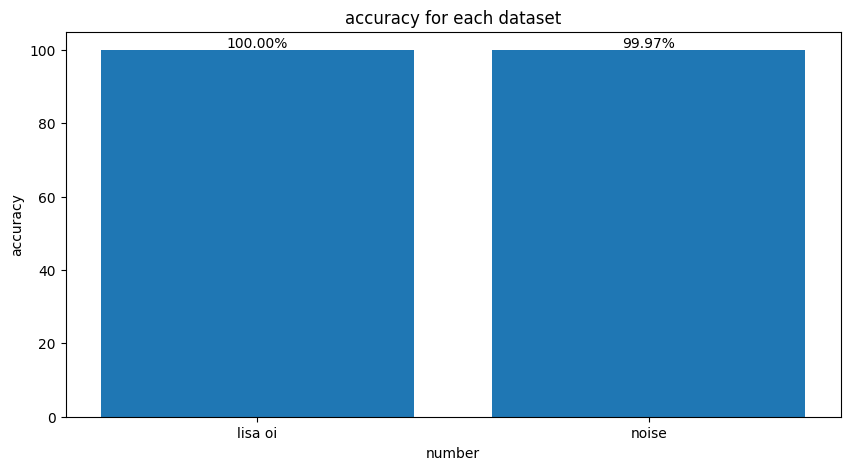

In [ ]:
acc_per = []
for i in range(0,2):
  sum_label = 0
  for j in range(0,2):
    sum_label = sum_label + conf_matrix[i][j]
  accu = float(conf_matrix[i][i]/sum_label)
  acc_per.append(round(accu,4)*100)
labels =  ['lisa oi','noise']
plt.figure(figsize=(10,5))
plt.bar(labels,acc_per)
for i in range(len(labels)):
    plt.text(labels[i], acc_per[i], f"{acc_per[i]:.2f}"+"%", ha='center', va='bottom')
plt.xlabel("number")
plt.ylabel("accuracy")
plt.title("accuracy for each dataset")
plt.show()

# Chuyển đổi mô hình sang Tensorflow Lite


In [ ]:
# Load model keras
keras_model = tf.keras.models.load_model("/content/best_model.h5")


converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model_quantize_f16 = converter.convert()

#lưu model tflite
with open("/content/drive/MyDrive/saved_model/wakeword_final.tflite", "wb") as f:
    f.write(tflite_model_quantize_f16)